In [2]:
from tqdm import tqdm
import sys
sys.path.append("/home/sambt/analytic-qg-classifiers/analysis/utils/")
from master import *
prefix = '/home/sambt/pythia83-samples/optimal-classifiers/kernel-1/'

In [3]:
fq = prefix+'H2qq-CF3.0CA3.0-sqg0100-esq0000-r0.4/total.root'
fg = prefix+'H2gg-CF3.0CA3.0-sqg0100-r0.4/total.root'
X,Y = tools.pre_process(fq,fg,nev_max=50000)
z = X[:,:,0].copy()
dEta = X[:,:,1].copy()
dPhi = X[:,:,2].copy()
dR = np.sqrt(dEta**2 + dPhi**2)
mults = np.count_nonzero(z,axis=1)
optimal = an.nk(z,1) + an.nk(z,2)

Loaded files at 0.08446335792541504
Read in arrays at 1.7513527870178223
Cleaned events at 1.8322420120239258
Made quark/gluon input arrays at 4.2908899784088135
Finished preprocessing at 11.049264907836914


In [4]:
pfn, pfn_roc, pfn_auc = tools.train_qg_pfn(X,Y,n_epoch=3,summary=False)
pfn_z, pfn_z_roc, pfn_z_auc = tools.train_qg_pfn_no_angular(X,Y,n_epoch=3,summary=False)
pfn_noz, pfn_noz_roc, pfn_noz_auc = tools.train_qg_pfn_only_angular(X,Y,n_epoch=3,summary=False)
efn, efn_roc, efn_auc = tools.train_qg_efn(X,Y,n_epoch=3,summary=False)

Model summary:
Train on 70000 samples, validate on 15000 samples
Epoch 1/3
70000/70000 [==============================] - 3s 43us/step - loss: 0.7103 - acc: 0.5027 - val_loss: 0.6936 - val_acc: 0.4985
Epoch 2/3
70000/70000 [==============================] - 1s 17us/step - loss: 0.6939 - acc: 0.5032 - val_loss: 0.6931 - val_acc: 0.5027
Epoch 3/3
70000/70000 [==============================] - 1s 17us/step - loss: 0.6932 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.5042
Finished training at 6.246918201446533

PFN AUC: 0.5087227869752708

Model summary:
Train on 70000 samples, validate on 15000 samples
Epoch 1/3
70000/70000 [==============================] - 2s 25us/step - loss: 0.7282 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.4989
Epoch 2/3
70000/70000 [==============================] - 1s 17us/step - loss: 0.6942 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4991
Epoch 3/3
70000/70000 [==============================] - 1s 17us/step - loss: 0.6936 - acc: 0.4959 - val_loss: 0.6933 - v

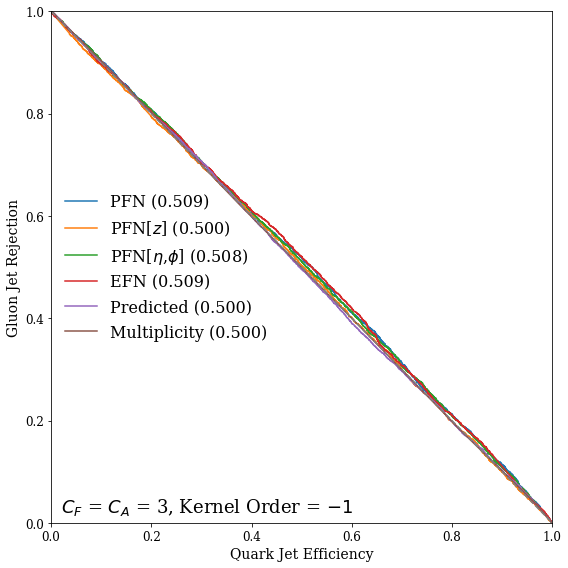

In [5]:
optimal_roc = roc_curve(Y[:,1],-optimal)
optimal_auc = roc_auc_score(Y[:,1],-optimal)
mult_roc = roc_curve(Y[:,1],mults)
mult_auc = roc_auc_score(Y[:,1],mults)
rocs = [pfn_roc,pfn_z_roc,pfn_noz_roc,efn_roc,optimal_roc,mult_roc]
aucs = [pfn_auc,pfn_z_auc,pfn_noz_auc,efn_auc,optimal_auc,mult_auc]
labels = ["PFN",r"PFN[$z$]",r"PFN[$\eta$,$\phi$]","EFN","Predicted","Multiplicity"]
plotting.plot_many(rocs,aucs,labels)

In [6]:
exponents = np.linspace(0,15,num=50)
aucs = []
for exp in tqdm(exponents):
    optimal = np.sum(np.power(z,exp,where=z>0,out=np.zeros(z.shape)),axis=1)
    #bottom = optimal.min()
    #optimal = optimal-bottom
    #optimal = optimal/optimal.max()
    auc = roc_auc_score(Y[:,1],optimal)
    if auc < 0.5:
        auc = 1-auc
    aucs.append(auc)

100%|██████████| 50/50 [00:02<00:00, 16.78it/s]


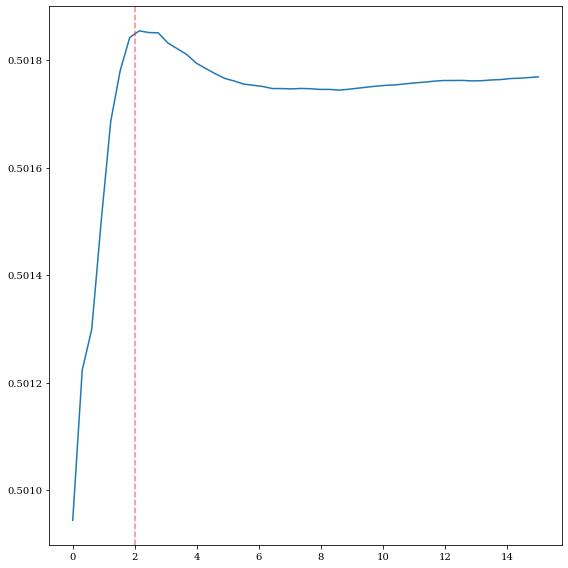

In [7]:
plt.plot(exponents,aucs)
plt.axvline(x=2,color='red',linestyle='--',alpha=0.5)

In [8]:
max_ind = np.argmax(aucs)
print("Highest auc is {0:.4f} at exponent = {1:.4f}".format(aucs[max_ind],exponents[max_ind]))
print("AUC at exp = -1 is {0:.4f}".format(optimal_auc))

Highest auc is 0.5019 at exponent = 2.1429
AUC at exp = -1 is 0.4982


In [8]:
exp_z = np.linspace(-4,10,num=71)
exp_theta = np.linspace(-4,10,num=71)
aucs_2d = np.zeros((exp_z.size,exp_theta.size))
for i, ez in enumerate(tqdm(exp_z)):
    for j, et in enumerate(exp_theta):
        zpow = np.power(z,ez,where=z>0.0,out=np.zeros(z.shape))
        rpow = np.power(dR,et,where=dR>0.0,out=np.zeros(dR.shape))
        opt = np.sum(zpow*rpow,axis=1)
        auc = roc_auc_score(Y[:,1],opt)
        if auc < 0.5:
            auc = 1-auc
        aucs_2d[i,j] = auc

100%|██████████| 71/71 [07:46<00:00,  6.57s/it]


In [9]:
#if we're loading it in
exp_z = np.linspace(-4,10,num=71)
exp_theta = np.linspace(-4,10,num=71)
aucs_2d = np.load("angularity_scan_auc2d_grid_qgsame.npy")

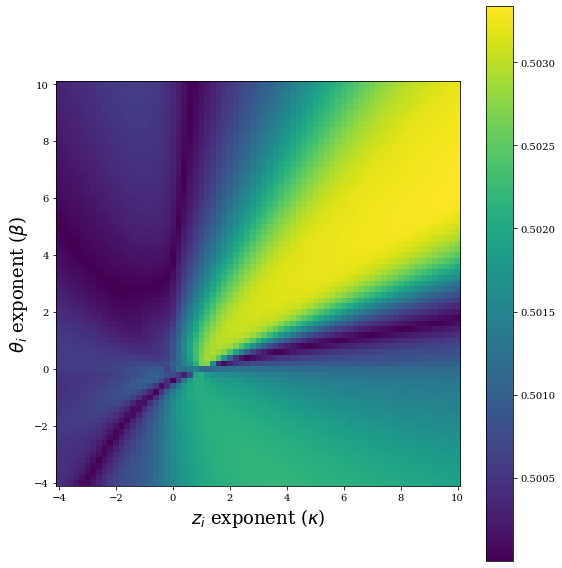

In [10]:
auc_grid = plt.imshow(aucs_2d.transpose(),origin='lower',extent=(-4.1,10.1,-4.1,10.1))
plt.colorbar(auc_grid)
plt.xlabel(r"$z_i$ exponent ($\kappa$)",fontsize=18)
plt.ylabel(r"$\theta_i$ exponent ($\beta$)",fontsize=18)
plt.savefig("angularity_scan_sqg0100-qgsame.pdf")

In [11]:
ix, iy = np.unravel_index(np.argmax(aucs_2d),aucs_2d.shape)
ix2, iy2 = np.unravel_index(np.argmin(aucs_2d),aucs_2d.shape)
print("Best AUC is {0:.6f} at kappa = {1:.2f}, beta = {2:.2f}".format(aucs_2d.max(),exp_z[ix],exp_theta[iy]))
print("Worst AUC is {0:.6f} at kappa = {1:.2f}, beta = {2:.2f}".format(aucs_2d.min(),exp_z[ix2],exp_theta[iy2]))

Best AUC is 0.503336 at kappa = 10.00, beta = 6.40
Worst AUC is 0.500000 at kappa = -1.80, beta = 2.80


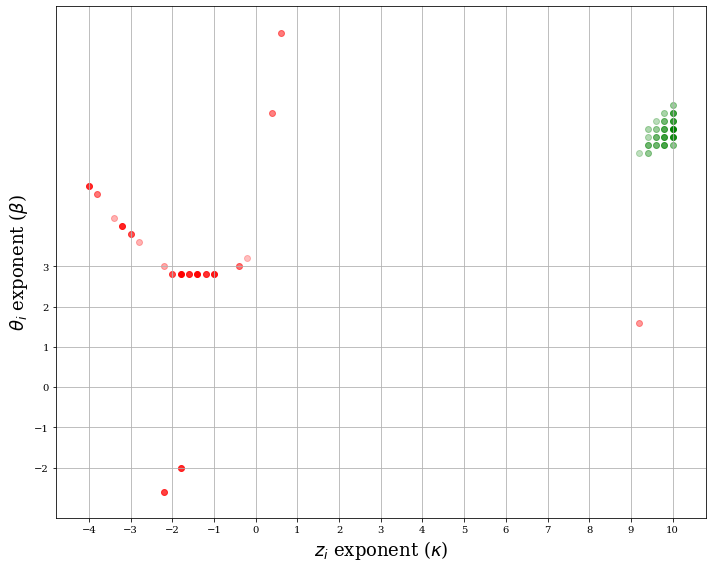

In [13]:
n = 20
worst = np.argsort(aucs_2d,axis=None)
worst_kappas = []
best_kappas = []
worst_betas = []
best_betas = []
best_aucs = []
worst_aucs = []
for k in range(n):
    ix_bad, iy_bad = np.unravel_index(worst[k],aucs_2d.shape)
    k_bad = exp_z[ix_bad]
    b_bad = exp_theta[iy_bad]
    auc_bad = aucs_2d[ix_bad,iy_bad]
    worst_kappas.append(k_bad)
    worst_betas.append(b_bad)
    worst_aucs.append(auc_bad)
    #print("{0}th worst AUC is {1:.6f} at kappa = {2:.2f}, beta = {3:.2f}".format(k,aucs_2d[ix_bad,iy_bad],exp_z[ix_bad],exp_theta[iy_bad]))
    
    ix_good, iy_good = np.unravel_index(worst[-1-k],aucs_2d.shape)
    k_good = exp_z[ix_good]
    b_good = exp_theta[iy_good]
    auc_good = aucs_2d[ix_good,iy_good]
    best_kappas.append(k_good)
    best_betas.append(b_good)
    best_aucs.append(auc_good)
    #print("{0}th best AUC is {1:.6f} at kappa = {2:.2f}, beta = {3:.2f}".format(k,aucs_2d[ix_good,iy_good],exp_z[ix_good],exp_theta[iy_good]))
plt.figure(1,(10,8))
best_aucs = np.array(best_aucs)
worst_aucs = np.array(worst_aucs)
alpha_good = tools.mapto(best_aucs,0.25,1)
alpha_bad = tools.mapto(-worst_aucs,0.25,1)
alpha_good = np.clip(alpha_good,0.25,1)
alpha_bad = np.clip(alpha_bad,0.25,1)
for i in range(n):
    plt.scatter(best_kappas[i],best_betas[i],color="green",alpha=alpha_good[i])
    plt.scatter(worst_kappas[i],worst_betas[i],color="red",alpha=alpha_bad[i])
plt.gca().set_xticks(np.linspace(-4,10,num=15))
plt.gca().set_yticks(np.linspace(-2,3,num=6))
plt.grid()
plt.xlabel(r"$z_i$ exponent ($\kappa$)",fontsize=18)
plt.ylabel(r"$\theta_i$ exponent ($\beta$)",fontsize=18)
plt.savefig("best{0}_angularities_sqg0100-qgsame.pdf".format(n))